# RL for Channel Selection
## Top-level simulation script

## Define functions to allow importing from Jupyter notebooks
Ref: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html

NB: This code should be moved to a utility library.

In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]
    
sys.meta_path.append(NotebookFinder())

## Begin main simulation run script.

In [3]:
from env import Env
from RL_brain import DeepQNetwork

importing Jupyter notebook from env.ipynb
importing Jupyter notebook from RL_brain.ipynb


## Simulation configuration parameters

In [4]:
sim = {
    'cfg' : {
        'run' : { # run parameters
            'numEpisodes'    : 100,  # num. of episodes to run
            'maxSteps'       : 2000, # max. num. of sim. steps
            'startLearnStep' : 200,  # start periodic training after this step num.
            'learnPeriod'    : 5,    # num. of steps between (re)training
        },
        'dqn' : { # DQN parameters
            'learningRate'      : 0.01, # please provide summary comments for each parameter
            'rewardDecay'       : 0.9,
            'eGreedy'           : 0.9,
            'replaceTargetIter' : 200,
            'memorySize'        : 2000,
        }
    }
}

## The run() command runs the main simulation loop.

In [5]:
def run():
    # For ease of access to run parameters.
    step = 0
    numEpisodes = sim['cfg']['run']['numEpisodes']
    maxSteps = sim['cfg']['run']['maxSteps']
    startLearnStep = sim['cfg']['run']['startLearnStep']
    learnPeriod = sim['cfg']['run']['learnPeriod']
    
    for episode in range(numEpisodes):
        # initial observation
        observation = env.reset()
        while step < maxSteps:
            # fresh env

            # Output current observation:
            print('{}: current env = {}\n'.format(step, env.__dict__))

            # RL choose action based on observation
            action = RL.choose_action(observation)
            if action == 0:
                action_ = "Channel_1"
            elif action == 1:
                action_ = "Channel_6"
            else:
                action_ = "Channel_11"
            print('{}: action_ = {}, observation = {}\n'.format(step, action_, observation))
            # print(observation)
            # RL take action and get next observation and reward
            observation_, reward = env.step(action_)

            RL.store_transition(observation, action, reward, observation_)

            if (step > startLearnStep) and (step % learnPeriod == 0):
                RL.learn()

            # swap observation
            observation = observation_

            # break while loop when end of this episode
            step += 1


## Main simulation routine

In [6]:
if __name__ == "__main__":
    # maze game
    env = Env()
    
    # For ease of access to DQN config. parameters.
    learningRate = sim['cfg']['dqn']['learningRate']
    rewardDecay = sim['cfg']['dqn']['rewardDecay']
    eGreedy = sim['cfg']['dqn']['eGreedy']
    replaceTargetIter = sim['cfg']['dqn']['replaceTargetIter']
    rewardDecay = sim['cfg']['dqn']['learningRate']    
    memorySize = sim['cfg']['dqn']['memorySize']
    
    RL = DeepQNetwork(env.n_actions, env.n_features,
                      learning_rate=learningRate,
                      reward_decay=rewardDecay,
                      e_greedy=eGreedy,
                      replace_target_iter=replaceTargetIter,
                      memory_size=memorySize,                   
                      )
    
    run()
    RL.plot_cost()

0: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 1, 'count': 1, 'count_history': [], 'time_env_state': {'current': {'Channel_1': array([-68.        , -91.        ,  27.        ,  64.92399403]), 'Channel_6': array([-28.        , -26.        ,  20.        ,  49.14502069]), 'Channel_11': array([-72.        , -92.        ,  24.        ,   1.75767386])}}}

0: action_ = Channel_11, observation = [-68.         -91.          27.          64.92399403]

2: action Channel_1 has max. value 90.44179995772605

1: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 2, 'count': 1, 'count_history': [1], 'time_env_state': {'current': {'Channel_1': array([-53.        , -71.        ,  27.        ,  89.48990876]), 'Channel_6': array([-26.        , -59.        ,  30.        , 


81: action_ = Channel_6, observation = [-75.        -22.         24.         79.8187624]

83: action Channel_11 has max. value 159.92106339495996

82: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_6', 'time': 83, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1], 'time_env_state': {'current': {'Channel_1': array([-68.        , -25.        ,  24.        ,  37.07935379]), 'Channel_6': array([-63.        , -50.        ,  27.        ,  41.39495334]), 'Channel_11': array([-68.        , -51.        ,  27.        ,  17.99313661])}}}

82: action_ = Channel_11, observation = [-63.         -50.          27.          41.39495334]

84: action Channel_6 has max. value 1

142: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 143, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1], 'time_env_state': {'current': {'Channel_1': array([ -3.       , -72.       ,  24.       ,  81.8791788]), 'Channel_6': array([-85.        , -94.        ,  30.        ,  63.66554645]), 'Channel_11': array([-54.        , -27.        ,  24.        ,  70.87640432])}}}

142: action_ = Channel_6, observation = [-54.         -27.          24.          70.87640432]

144: a

201: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 202, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1], 'time_env_state': {'current': {'Channel_1': array([-20.        , -89.        ,  27.        ,  50.17336767]), 'Channel_6': array([-35.        , -47.        ,  27.        ,  43.15419973]), 'C


241: action_ = Channel_11, observation = [-54.         -26.          24.          48.87809944]

243: action Channel_6 has max. value 125.1109272309183

242: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 243, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1


299: action_ = Channel_1, observation = [-36.         -61.          30.          50.95784671]

301: action Channel_6 has max. value 122.73285615662624

300: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 301, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1,


346: action_ = Channel_1, observation = [-23.         -90.          27.          57.30743794]

348: action Channel_1 has max. value 87.95832346461182

348: selected action = action with max. value, reward = Channel_1

347: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 348, 'count': 2, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4,


396: action Channel_6 has max. value 130.09502790789765

395: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 396, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 


441: action_ = Channel_1, observation = [-42.         -97.          20.          13.86173348]

443: action Channel_11 has max. value 128.44494564012976

442: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 443, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1


491: action Channel_1 has max. value 140.6855213864379

491: selected action = action with max. value, reward = Channel_1

490: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 491, 'count': 2, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1


537: action_ = Channel_1, observation = [-37.         -20.          30.           3.34478725]

539: action Channel_1 has max. value 170.00654739933628

539: selected action = action with max. value, reward = Channel_1

538: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 539, 'count': 4, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4


596: action_ = Channel_1, observation = [-19.         -19.          30.          41.12784976]

598: action Channel_1 has max. value 108.89812911895172

598: selected action = action with max. value, reward = Channel_1

597: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 598, 'count': 3, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4


646: action_ = Channel_1, observation = [ -3.         -78.          27.          83.09443431]

648: action Channel_11 has max. value 199.8382689984797

647: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 648, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1,


692: action Channel_1 has max. value 202.1628635769971

691: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 692, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1


736: action_ = Channel_1, observation = [-94.         -89.          30.          93.40853872]

738: action Channel_6 has max. value 179.48362857942462

737: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 738, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1,


781: action_ = Channel_11, observation = [-96.         -29.          30.          38.13664876]

783: action Channel_1 has max. value 139.84981756585483

782: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 783, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 


836: action_ = Channel_1, observation = [-68.         -33.          30.           4.39547198]

838: action Channel_1 has max. value 92.15663316905503

838: selected action = action with max. value, reward = Channel_1

837: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 838, 'count': 3, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4,

890: action_ = Channel_1, observation = [-96.         -37.          30.          56.02240459]

892: action Channel_6 has max. value 138.31814104258476

891: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 892, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 


936: action_ = Channel_1, observation = [-45.         -70.          30.          56.81131323]

938: action Channel_1 has max. value 144.29053517764436

938: selected action = action with max. value, reward = Channel_1

937: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 938, 'count': 2, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4


985: action Channel_6 has max. value 188.74753083970046

985: selected action = action with max. value, reward = Channel_6

984: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_6', 'time': 985, 'count': 2, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 


1030: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 1031, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 3, 1, 1, 1, 1,


1074: action Channel_6 has max. value 154.41018990650508

1073: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 1074, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1


1114: selected action = action with max. value, reward = Channel_11

1113: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 1114, 'count': 2, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 1, 1, 1


1146: action_ = Channel_11, observation = [-100.          -82.           30.            1.11416245]

1148: action Channel_1 has max. value 129.94361853194002

1147: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 1148, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2


1178: action_ = Channel_11, observation = [-21.         -61.          30.          51.65788296]

1180: action Channel_11 has max. value 160.83153985691877

1180: selected action = action with max. value, reward = Channel_11

1179: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 1180, 'count': 2, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1

1216: action_ = Channel_11, observation = [-18.         -48.          20.          71.19022304]

1218: action Channel_6 has max. value 131.08654362500903

1217: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 1218, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 


1259: action Channel_11 has max. value 111.11189954382753

1259: selected action = action with max. value, reward = Channel_11

1258: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 1259, 'count': 3, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1,


1308: action Channel_1 has max. value 117.47664907116544

1308: selected action = action with max. value, reward = Channel_1

1307: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 1308, 'count': 2, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2,

1354: action_ = Channel_1, observation = [-91.         -24.          24.          17.17344108]

1356: action Channel_6 has max. value 152.7092412875233

1355: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 1356, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 

1391: action Channel_1 has max. value 99.50459016847796

1391: selected action = action with max. value, reward = Channel_1

1390: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 1391, 'count': 2, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1


1431: action_ = Channel_1, observation = [ -5.        -37.         30.         53.3115113]

1433: action Channel_11 has max. value 96.80968619035798

1432: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 1433, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1,


1476: action Channel_1 has max. value 149.73409637750802

1476: selected action = action with max. value, reward = Channel_1

1475: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 1476, 'count': 2, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2,


1522: action_ = Channel_1, observation = [-68.          -2.          27.          19.68793037]

1524: action Channel_1 has max. value 132.21475157381198

1524: selected action = action with max. value, reward = Channel_1

1523: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 1524, 'count': 2, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




1738: action Channel_6 has max. value 165.69171099286774

1737: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 1738, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 2, 

1767: action Channel_11 has max. value 170.12192037424504

1767: selected action = action with max. value, reward = Channel_11

1766: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 1767, 'count': 2, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 


1795: action Channel_1 has max. value 150.26953762859046

1794: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 1795, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 2, 


1826: action_ = Channel_11, observation = [-56.         -68.          24.          28.80624479]

1828: action Channel_11 has max. value 126.84385741535928

1828: selected action = action with max. value, reward = Channel_11

1827: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 1828, 'count': 3, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1

1858: action_ = Channel_1, observation = [-19.         -90.          20.          30.84173926]

1860: action Channel_6 has max. value 164.41905280103416

1859: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_1', 'time': 1860, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2,


1891: action Channel_11 has max. value 151.57940765383293

1891: selected action = action with max. value, reward = Channel_11

1890: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 1891, 'count': 3, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1,

1940: action_ = Channel_11, observation = [-88.         -13.          24.          95.26265373]

1942: action Channel_11 has max. value 163.8930815166421

1942: selected action = action with max. value, reward = Channel_11

1941: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 1942, 'count': 2, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 

1986: action_ = Channel_11, observation = [-46.         -50.          27.          68.80003802]

1988: action Channel_1 has max. value 142.9704568647054

1987: current env = {'actions': ['Channel_1', 'Channel_6', 'Channel_11'], 'tx_power_list': [20, 24, 27, 30], 'n_actions': 3, 'n_features': 4, 'state': 'Channel_11', 'time': 1988, 'count': 1, 'count_history': [1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 3, 1, 2, 1, 2, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 1, 2, 3, 4, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 1, 1, 1, 2, 3, 4, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 3, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 1, 2, 3, 1, 2, 1, 1, 2, 3, 1, 2, 3, 4, 1, 1, 2, 3, 4, 5, 6, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 4, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1, 1, 2, 1, 2

In [7]:
RL.plot_cost()

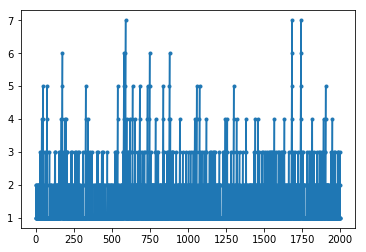

In [8]:
# Trace of number of times selection action is max. value action.
plt.plot(env.count_history, '.-') 